# EuroSAT GAN Implementation

This notebook implements a Generative Adversarial Network (GAN) for generating synthetic satellite images based on the EuroSAT dataset. The implementation includes:

- Data loading and preprocessing
- Generator network architecture
- Discriminator network architecture
- Training loop and loss functions
- Visualization of generated images

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tqdm import tqdm
import time
from datetime import datetime, timedelta

In [2]:
# Load EuroSAT dataset
dataset = tfds.load('eurosat/rgb', split='train')

# Convert to numpy array and normalize
def preprocess(data):
    image = data['image']
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

# Prepare the dataset
BUFFER_SIZE = 1000
BATCH_SIZE = 32

train_dataset = (
    dataset
    .map(preprocess)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

# Check for physical GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

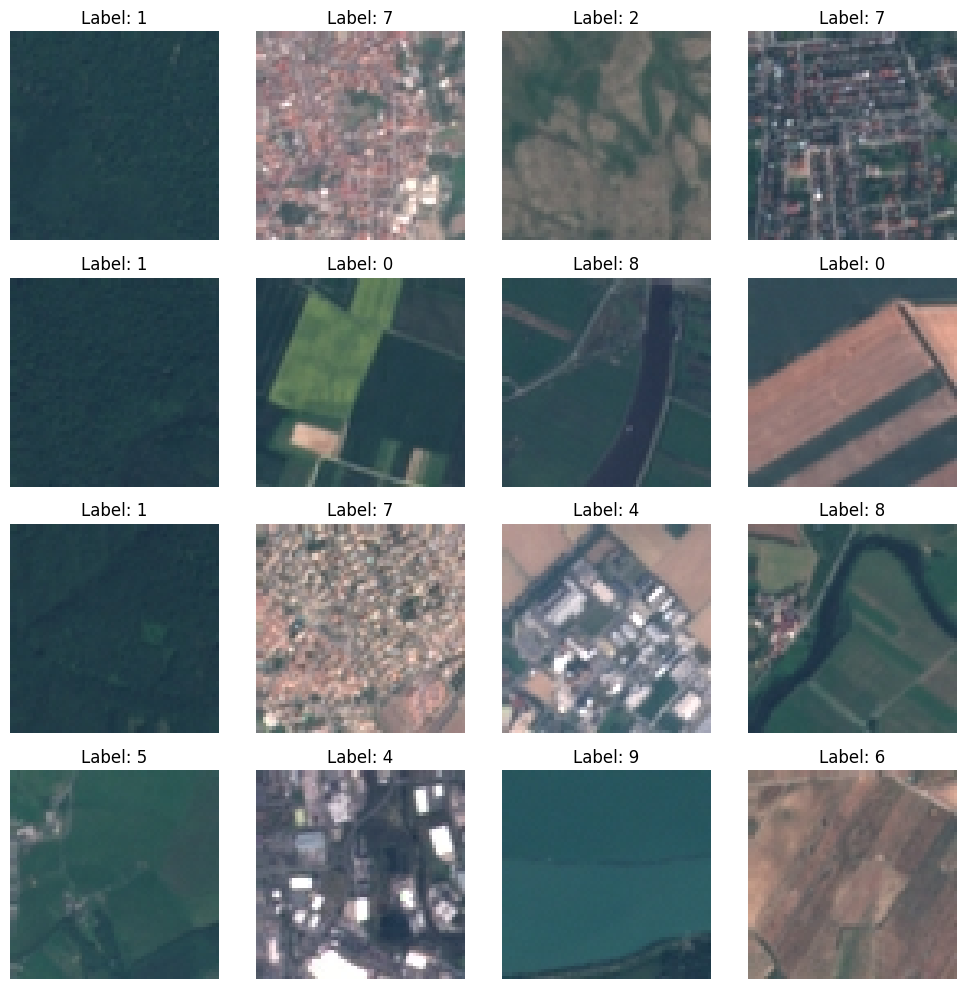

In [3]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, example in enumerate(dataset.take(16)):
    image = example['image'].numpy()
    label = example['label'].numpy()
    ax = axes[i // 4, i % 4]
    ax.imshow(image)
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## GAN Implementation

In [4]:
def make_generator():
    """
    Creates and returns a generator model for the GAN.

    The generator takes random noise as input and generates synthetic images with dimensions
    of 64x64x3 (matching the EuroSAT dataset).

    Returns:
        model (tf.keras.Sequential): The generator model
    """
    model = tf.keras.Sequential([
        # Input layer
        layers.Input(shape=(100,)),

        # Fully connected layer to reshape
        layers.Dense(8 * 8 * 256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),

        # First upsampling: 8x8 -> 16x16
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Second upsampling: 16x16 -> 32x32
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Third upsampling: 32x32 -> 64x64
        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Final output layer: 64x64x3
        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = make_generator()

In [5]:
def make_discriminator():
    """
    Creates and returns a discriminator model for the GAN.

    The discriminator takes 64x64x3 images as input and outputs a binary classification
    (real vs fake).

    Returns:
        model (tf.keras.Sequential): The discriminator model
    """
    model = tf.keras.Sequential([
        # Input layer
        layers.Input(shape=(64, 64, 3)),

        # First convolutional layer
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        # Second convolutional layer
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        # Third convolutional layer
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        # Flatten the feature maps
        layers.Flatten(),

        # Output layer
        layers.Dense(1)  # Binary classification (real vs fake)
    ])
    return model

discriminator = make_discriminator()

In [6]:
print("\n===== Generator Summary =====")
generator.summary()

print("\n===== Discriminator Summary =====")
discriminator.summary()



===== Generator Summary =====


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │         2,400 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,782,432 (10.61 MB)

 Trainable params: 2,749,216 (10.49 MB)

 Non-trainable params: 33,216 (129.75 KB)


===== Discriminator Summary =====


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,045,633 (3.99 MB)

 Trainable params: 1,045,633 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [8]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [9]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

def train(dataset, epochs):
    start_time = time.time()

    # Initialize lists to store losses for plotting
    gen_losses = []
    disc_losses = []

    # Create progress bar for epochs
    epoch_progress = tqdm(range(epochs), desc='Training Progress')

    for epoch in epoch_progress:
        batch_gen_losses = []
        batch_disc_losses = []

        # Create progress bar for batches
        batch_progress = tqdm(dataset, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)

        for image_batch in batch_progress:
            # Your existing training steps here
            gen_loss, disc_loss = train_step(image_batch)

            batch_gen_losses.append(gen_loss)
            batch_disc_losses.append(disc_loss)

            # Update batch progress
            batch_progress.set_postfix({
                'Gen Loss': f'{gen_loss:.4f}',
                'Disc Loss': f'{disc_loss:.4f}'
            })

        # Calculate average losses for this epoch
        avg_gen_loss = sum(batch_gen_losses) / len(batch_gen_losses)
        avg_disc_loss = sum(batch_disc_losses) / len(batch_disc_losses)
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        # Calculate time metrics
        elapsed_time = time.time() - start_time
        avg_time_per_epoch = elapsed_time / (epoch + 1)
        estimated_time_remaining = avg_time_per_epoch * (epochs - epoch - 1)

        # Update epoch progress bar with detailed metrics
        epoch_progress.set_postfix({
            'Gen Loss': f'{avg_gen_loss:.4f}',
            'Disc Loss': f'{avg_disc_loss:.4f}',
            'Elapsed': str(timedelta(seconds=int(elapsed_time))),
            'Remaining': str(timedelta(seconds=int(estimated_time_remaining))),
            'Progress': f'{((epoch + 1) / epochs) * 100:.1f}%'
        })

        # Save sample images every 10 epochs
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1)

            # Print detailed summary
            print(f'\nEpoch {epoch + 1}/{epochs} Summary:')
            print(f'Average Generator Loss: {avg_gen_loss:.4f}')
            print(f'Average Discriminator Loss: {avg_disc_loss:.4f}')
            print(f'Time Elapsed: {str(timedelta(seconds=int(elapsed_time)))}')
            print(f'Estimated Time Remaining: {str(timedelta(seconds=int(estimated_time_remaining)))}')
            print(f'Training Progress: {((epoch + 1) / epochs) * 100:.1f}%')
            print(f'Timestamp: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}\n')

    # Return losses for plotting
    return gen_losses, disc_losses


In [10]:
def plot_training_progress(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.title('Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i] * 0.5 + 0.5)  # Scale back to [0,1]
        plt.axis('off')

    plt.savefig(f'eurosat_gan_epoch_{epoch:04d}.png')
    plt.close()

In [ ]:
gen_losses, disc_losses = train(train_dataset, epochs=EPOCHS)
print("Training complete!")
plot_training_progress(gen_losses, disc_losses)

Epoch 2/100:  25%|██▌       | 214/844 [01:50<05:17,  1.98it/s, Gen Loss=3.4545, Disc Loss=0.5311]